In [38]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture

In [39]:
wazp_members = Table.read('y1a1_dnf_wazp_v5.0.11.5943+39_members.fits', format='fits')

mask_z = (wazp_members['ZP'] > 0.5) & (wazp_members['ZP'] < 0.6)
mask_ra = (wazp_members['RA'] > 40) & (wazp_members['RA'] < 50)
mask_dec = (wazp_members['DEC'] > -50) & (wazp_members['DEC'] < -40)
mask = mask_z & mask_ra & mask_dec

membros = wazp_members[mask]

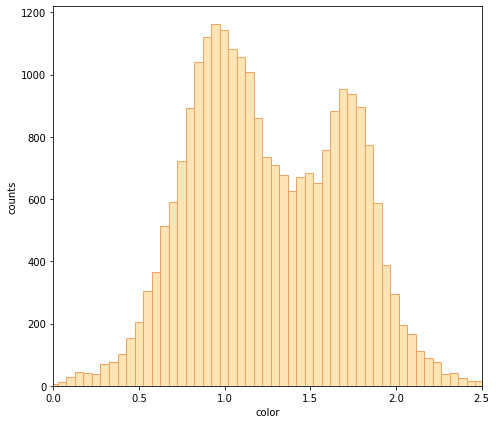

In [40]:
mag1 = 'g'
mag2 = 'r'

plt.figure(figsize=[7,6])
color = np.array(membros[f'mag_{mag1}']) - np.array(membros[f'mag_{mag2}'])
plt.hist(color, fc="moccasin", ec='sandybrown', bins='auto')
plt.xlabel("color")
plt.ylabel("counts")
plt.xlim(0, 2.5)
plt.grid(False)
plt.tight_layout()

### com curve_fit

In [41]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

             params       err
mu1        0.992889  0.002479
sigma1     0.270179  0.002652
A1      1148.866188  6.858270
mu2        1.718218  0.002685
sigma2     0.192366  0.002602
A2       895.702712  8.053729


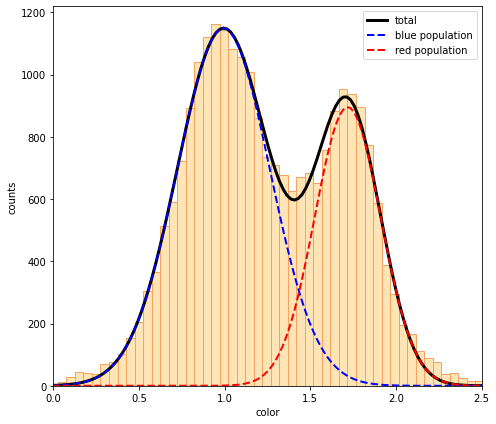

In [42]:
plt.figure(figsize=[7,6])
y,x,_=plt.hist(color, bins='auto', weights=None, fc="moccasin", ec='sandybrown')
x=(x[1:]+x[:-1])/2

expected = (1.0, 0.2, 1100.0, 1.8, 0.2, 1000.0) #(mu1, sigma1, A1, mu2, sigma2, A2)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)

plt.plot(x_fit, bimodal(x_fit, *params), color='black', lw=3, label='total')
plt.plot(x_fit, gauss(x_fit, *params[0:3]), color='blue', lw=2, ls="--", label='blue population')
plt.plot(x_fit, gauss(x_fit, *params[3:6]), color='red', lw=2, ls="--", label='red population')
plt.legend()
plt.xlabel("color")
plt.ylabel("counts")
plt.xlim(0, 2.5)

data = pd.DataFrame(data={'params': params, 'err': sigma}, index=bimodal.__code__.co_varnames[1:])
print(data)
plt.tight_layout()

### com GaussianMixture

(0.9436041030421738, 0.273897885427023, 0.5439709606704506, 1.64256928839233, 0.33145247364314545, 0.4560290393295514)
          params       err
mu1     0.992890  0.002479
sigma1  0.270180  0.002652
A1      0.932797  6.858270
mu2     1.718219  0.002685
sigma2  0.192365  0.002602
A2      0.727248  8.053729


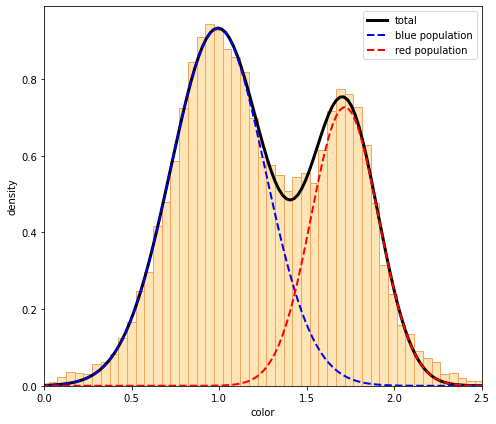

In [45]:
color2=color.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, max_iter=1000, random_state=1, covariance_type="full").fit(color2)

mean = gmm.means_
covs  = gmm.covariances_
weights = gmm.weights_

mu1 = float(mean[0][0])
A1 = float(weights[0])
cov1= float(covs[0][0][0])
sigma1 = np.sqrt((cov1))
mu2 = float(mean[1][0])
A2 = float(weights[1])
cov2 = float(covs[1][0][0])
sigma2 = np.sqrt((cov2))

expected = (mu1, sigma1, A1, mu2, sigma2, A2)
print(expected)



plt.figure(figsize=[7,6])
y,x,_=plt.hist(color, bins='auto', weights=None, density=True, fc="moccasin", ec='sandybrown')
x=(x[1:]+x[:-1])/2

params, cov = curve_fit(bimodal, x, y, expected)
x_fit = np.linspace(x.min(), x.max(), 500)

plt.plot(x_fit, bimodal(x_fit, *params), color='black', lw=3, label='total')
plt.plot(x_fit, gauss(x_fit, *params[0:3]), color='blue', lw=2, ls="--", label='blue population')
plt.plot(x_fit, gauss(x_fit, *params[3:6]), color='red', lw=2, ls="--", label='red population')
plt.legend()
plt.xlabel("color")
plt.ylabel("density")
plt.xlim(0, 2.5)

data = pd.DataFrame(data={'params': params, 'err': sigma}, index=bimodal.__code__.co_varnames[1:])
print(data)
plt.tight_layout()